In [1]:
!pip install pandas

In [3]:
import pandas as pd

# Specify the path to your Excel file
file_path = r"C:\Users\karan\OneDrive\Desktop\GitHub Projects\GBA_TED_Youtube Video.xlsx"  # Make sure this file is in the same directory as your notebook, or provide the full path

# Read the Excel file into a pandas DataFrame
df = pd.read_excel(file_path)

# Display the first few rows of the DataFrame to verify
print(df.head())

                                             comment
0  The United States is one of the only wealthy n...
1  Nah.... watching this almost through 2025 is s...
2  only way to accomplish this is to kill 80% of ...
3  As long as Capitalist is the norm, some SDG is...
4  A decade has passed, and the world is in a wor...


In [4]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

# Download necessary NLTK data (only needs to be done once)
nltk.download('punkt')
nltk.download('stopwords')

# --- 1. Remove missing rows ---
# This operation modifies the DataFrame directly.
# It removes rows where the 'comment' column is empty or NaN.
df.dropna(subset=['comment'], inplace=True)


# --- 2. Tokenize it ---
# The .apply() method is used to apply the word_tokenize function to each comment.
df['tokenized_comment'] = df['comment'].apply(word_tokenize)


# --- 3. Make every text in the text column lowercase ---
# The .str.lower() method is a vectorized string function that converts all characters to lowercase. [2, 9, 10, 11]
df['lowercase_comment'] = df['comment'].str.lower()


# --- 4. Remove special characters ---
# This uses a regular expression to remove characters that are not words or spaces. [3, 6, 7, 12]
df['no_special_chars_comment'] = df['lowercase_comment'].str.replace(r'[^\w\s]', '', regex=True)


# --- 5. Remove stopwords ---
# First, get the list of English stopwords from NLTK. [25]
stop_words = set(stopwords.words('english'))

# This function removes stopwords from a list of tokens.
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

# Tokenize the column with no special characters first
df['tokenized_no_special_chars'] = df['no_special_chars_comment'].apply(word_tokenize)
# Then apply the remove_stopwords function. [8]
df['no_stopwords_comment'] = df['tokenized_no_special_chars'].apply(remove_stopwords)


# Display the DataFrame with the new columns
print(df[['comment', 'tokenized_comment', 'lowercase_comment', 'no_special_chars_comment', 'no_stopwords_comment']].head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\karan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                             comment  \
0  The United States is one of the only wealthy n...   
1  Nah.... watching this almost through 2025 is s...   
2  only way to accomplish this is to kill 80% of ...   
3  As long as Capitalist is the norm, some SDG is...   
4  A decade has passed, and the world is in a wor...   

                                   tokenized_comment  \
0  [The, United, States, is, one, of, the, only, ...   
1  [Nah, ...., watching, this, almost, through, 2...   
2  [only, way, to, accomplish, this, is, to, kill...   
3  [As, long, as, Capitalist, is, the, norm, ,, s...   
4  [A, decade, has, passed, ,, and, the, world, i...   

                                   lowercase_comment  \
0  the united states is one of the only wealthy n...   
1  nah.... watching this almost through 2025 is s...   
2  only way to accomplish this is to kill 80% of ...   
3  as long as capitalist is the norm, some sdg is...   
4  a decade has passed, and the world is in a 

In [5]:
!pip install textblob

In [6]:
from textblob import TextBlob

# --- Perform Sentiment Analysis ---

# TextBlob works on strings, so we need to join the list of words in 'no_stopwords_comment' back into a single string.
# We'll create a temporary column for this.
df['processed_comment_str'] = df['no_stopwords_comment'].apply(lambda tokens: ' '.join(tokens))

# 1. Calculate Sentiment Score (Polarity)
# The .apply() method is used to apply the TextBlob sentiment analysis to each processed comment.
# The .sentiment.polarity attribute gives a score from -1 (very negative) to +1 (very positive).
df['sentiment_score'] = df['processed_comment_str'].apply(lambda text: TextBlob(text).sentiment.polarity)

# 2. Categorize Sentiment
# This function categorizes the sentiment based on the polarity score.
def get_sentiment_category(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the categorization function to the 'sentiment_score' column.
df['sentiment_category'] = df['sentiment_score'].apply(get_sentiment_category)


# --- Export to a new Excel file ---

# Define the name for your new Excel file
output_file_path = 'sentiment_analysis_results.xlsx'

# Select all original columns plus the new sentiment columns for the output
# We will drop the intermediate processing columns to keep the final output clean.
final_df = df.drop(columns=['tokenized_comment', 'lowercase_comment', 'no_special_chars_comment',
                            'tokenized_no_special_chars', 'no_stopwords_comment', 'processed_comment_str'])


# Export the final DataFrame to an Excel file
# The index=False argument prevents pandas from writing the DataFrame index as a column in the Excel file.
final_df.to_excel(output_file_path, index=False)

print(f"Sentiment analysis complete. The results have been saved to '{output_file_path}'")
print("\nHere's a preview of the final data:")
print(final_df[['comment', 'sentiment_score', 'sentiment_category']].head())

Sentiment analysis complete. The results have been saved to 'sentiment_analysis_results.xlsx'

Here's a preview of the final data:
                                             comment  sentiment_score  \
0  The United States is one of the only wealthy n...            0.580   
1  Nah.... watching this almost through 2025 is s...           -0.250   
2  only way to accomplish this is to kill 80% of ...            0.000   
3  As long as Capitalist is the norm, some SDG is...           -0.025   
4  A decade has passed, and the world is in a wor...           -0.400   

  sentiment_category  
0           Positive  
1           Negative  
2            Neutral  
3           Negative  
4           Negative  


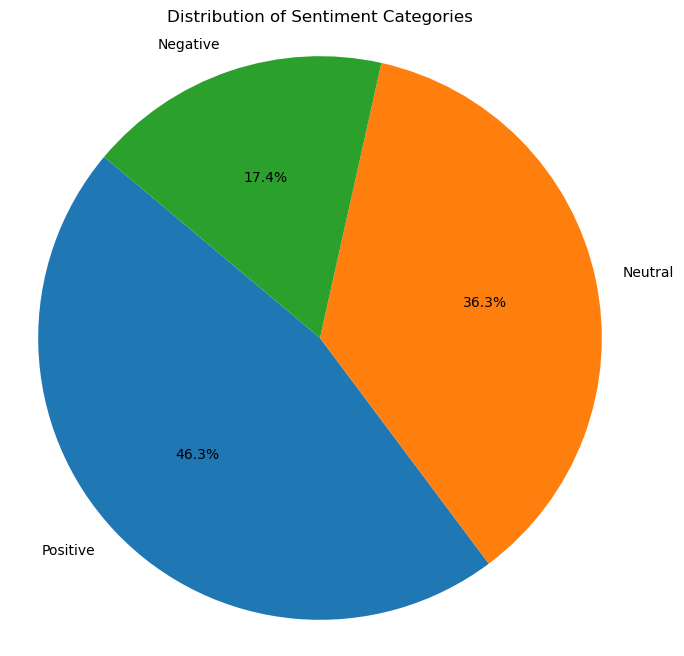

In [7]:
import matplotlib.pyplot as plt

# --- Plot a Pie Chart of Sentiment Categories ---

# 1. Count the occurrences of each sentiment category
sentiment_counts = df['sentiment_category'].value_counts()

# 2. Create the pie chart
plt.figure(figsize=(8, 8)) # Optional: Adjusts the size of the figure
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)

# 3. Add a title
plt.title('Distribution of Sentiment Categories')

# 4. Ensure the pie chart is a circle
plt.axis('equal')

# 5. Display the chart
plt.show()

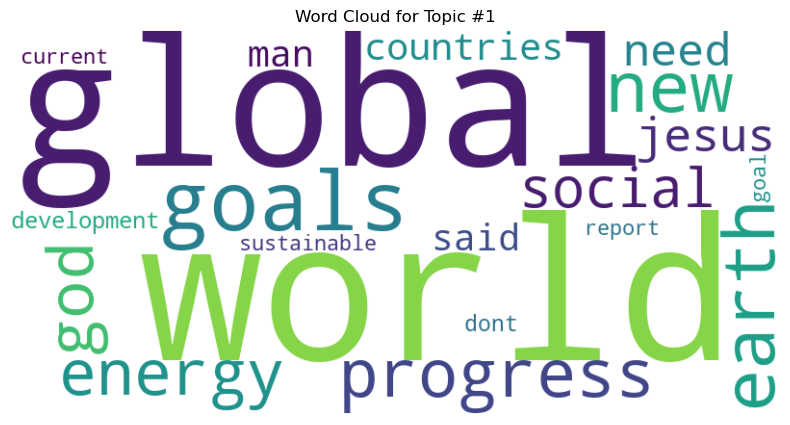

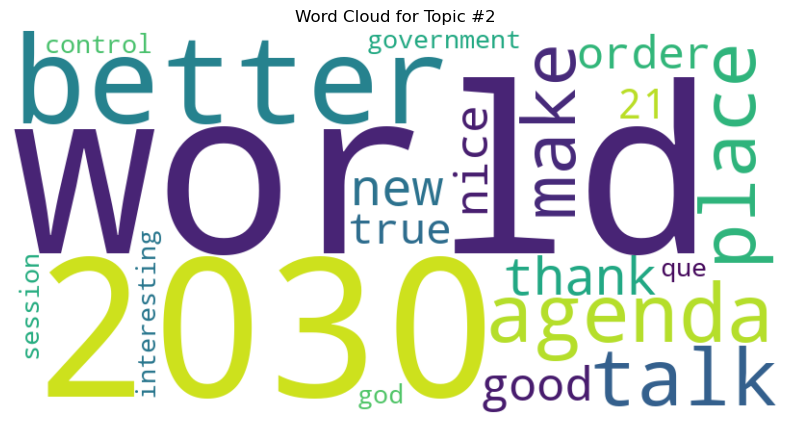

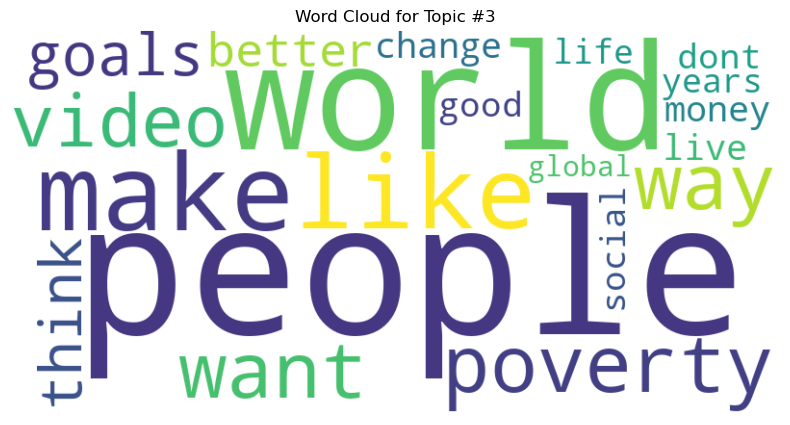

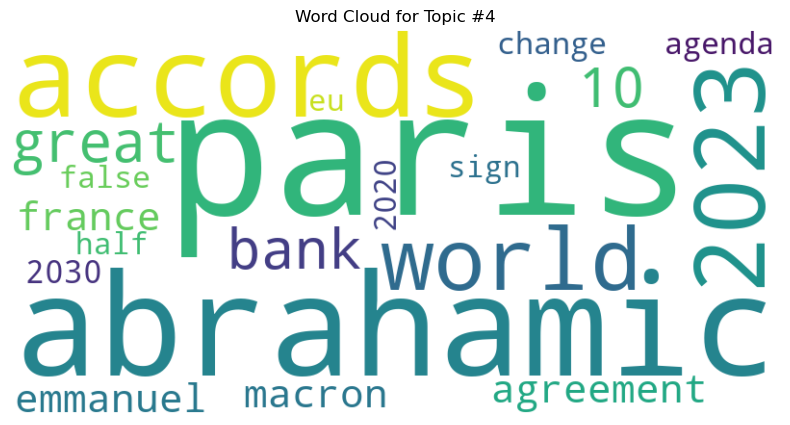

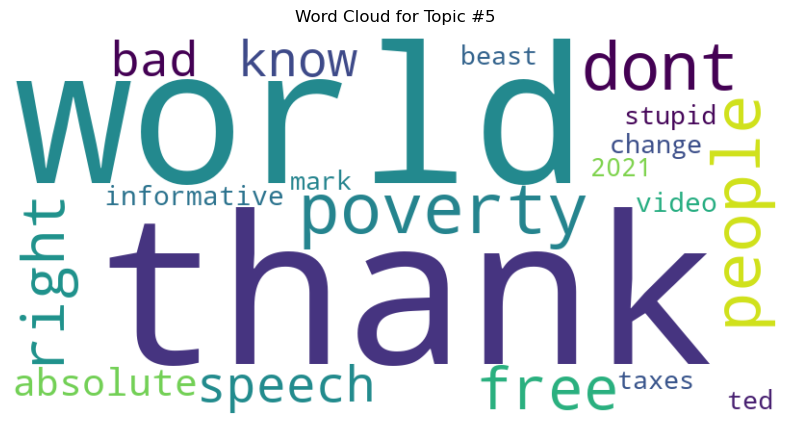

In [9]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud

# --- 1. Prepare Data for Topic Modeling ---

# We will use the 'no_stopwords_comment' column. First, ensure it's in string format.
# If it's still a list of words, we'll join them into a single string per comment.
df['text_for_lda'] = df['no_stopwords_comment'].apply(lambda tokens: ' '.join(tokens))

# Create a Document-Term Matrix
# This matrix will show the frequency of each word in each document (comment).
# max_df=0.95 ignores words that appear in more than 95% of the documents (too common).
# min_df=2 ignores words that appear in less than 2 documents (too rare).
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(df['text_for_lda'])


# --- 2. Apply LDA Model ---

# Define the number of topics you want to find. You can adjust this number.
num_topics = 5 # Example: trying to find 5 topics

# Create and fit the LDA model
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(doc_term_matrix)


# --- 3. Generate Word Clouds for Each Topic ---

# Get the feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Loop through each topic
for topic_idx, topic in enumerate(lda.components_):
    # Get the top words for the current topic
    # We create a dictionary of words and their weights in the topic
    topic_words = {feature_names[i]: topic[i] for i in topic.argsort()[:-21:-1]} # Top 20 words

    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_words)

    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Topic #{topic_idx + 1}')
    plt.axis('off')
    plt.show()

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# --- 1. Prepare Data for NMF ---

# NMF works on string data, so we'll join the tokens from 'no_stopwords_comment' into a single string for each comment.
# We can reuse the 'text_for_lda' column if it was created, or create a new one.
df['text_for_nmf'] = df['no_stopwords_comment'].apply(lambda tokens: ' '.join(tokens))

# Create a TF-IDF Vectorizer
# This will convert our text data into a matrix of TF-IDF features.
# max_df=0.95 ignores words that appear in more than 95% of the documents.
# min_df=2 ignores words that appear in less than 2 documents.
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text_for_nmf'])


# --- 2. Apply NMF Model ---

# Define the number of topics
num_topics = 5

# Create and fit the NMF model
# n_components specifies the number of topics.
# random_state ensures that the results are reproducible.
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_model.fit(tfidf_matrix)


# --- 3. Display the Topics ---

# Get the feature names (words) from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Function to display the top words for each topic
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        # Print the topic number
        print(f"Topic #{topic_idx + 1}:")
        # Print the top words for that topic
        top_words = " ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]])
        print(top_words)
    print("\n")

# Display the top 15 words for each of the 5 topics
print("Top words for each topic identified by NMF:")
display_topics(nmf_model, feature_names, 15)

Top words for each topic identified by NMF:
Topic #1:
paris abrahamic accords agreement macron france emmanuel bank 2023 10 great world 2020 islam chaos
Topic #2:
better world place make 2030 order new agenda humans excellent start speech dr going government
Topic #3:
thank sir informative presentation useful lecture video tedx excellent words valuable marvelous beautiful energy interesting
Topic #4:
people goals global dont video poverty world think like social way change development achieve want
Topic #5:
talk nice excellent interesting ted good amazing information informative sir session presentation marvelous person enjoyed


